# PROJET 5 - Catégorisez automatiquement des questions

# Importation des librairies

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import f1_score, make_scorer, accuracy_score, jaccard_score, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.feature_extraction.text import TfidfVectorizer

import timeit
from joblib import dump, load
from google.colab import files

# Chargement des jeux de données

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/OpenClassrooms/Projet_5/QueryResults_clean.csv'
data = pd.read_csv(path, sep = ",", na_filter=False)

# Définition des fonctions

In [ ]:
from sklearn.metrics import make_scorer

def cross_validation(X_train,y_train, param_grid, MODELE, CV):
  score = 'accuracy'

  # Créer un classifieur avec recherche d'hyperparamètre par validation croisée
  model = GridSearchCV(MODELE, param_grid, cv=CV, scoring = score) 

  # Optimiser ce classifieur sur le jeu d'entraînement
  mod = model.fit(X_train, y_train)
 
  return model.best_params_, mod

In [ ]:
def resultats_cross_validation(model_best_params_, model):
  #score = make_scorer(metrics.r2_score)
  score = 'accuracy'

  # Afficher le(s) hyperparamètre(s) optimaux
  print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
  print(model_best_params_)
  
  # Afficher les performances correspondantes
  print("Résultats de la validation croisée :")
  for mean, std, params in zip(model.cv_results_['mean_test_score'], model.cv_results_['std_test_score'], model.cv_results_['params']):
    print("{} = {:.3f} (+/-{:.03f}) for {}".format(score, mean, std*2, params))

In [ ]:
def modele_hyperparametre(nom_modele, X_train,y_train, X_test, y_test, model_best_params_, mod):
  ## On a maintenant l'hyperparamètre optimal trouvé par validation croisée
  
  ## Calcul des vitesses d'éxécution
  start_time = timeit.default_timer()

  # Résultats sur le jeu d'entraînement
  y_train_predict = mod.predict(X_train)
  elapsed_1 = timeit.default_timer() - start_time
  accuracy_score_train = accuracy_score(y_train, y_train_predict)
  jaccard_score_train = jaccard_score(y_train, y_train_predict, average='micro')
  f1_score_train = f1_score(y_train, y_train_predict, average='micro')

  # Prédiction sur le jeu de données test
  y_pred_model = mod.predict(X_test)
  elapsed_2 = timeit.default_timer() - start_time
  accuracy_score_test = accuracy_score(y_test, y_pred_model)
  jaccard_score_test = jaccard_score(y_test, y_pred_model, average='micro')
  f1_score_test = f1_score(y_test, y_pred_model, average='micro')

  liste_resultats = [nom_modele, accuracy_score_train, jaccard_score_train, f1_score_train, accuracy_score_test, jaccard_score_test, f1_score_test, elapsed_1, elapsed_2, model_best_params_]

  return liste_resultats, y_pred_model, mod

# Approche supervisée : Classification des Tags à partir des messages normalisés sur Body

## Création des jeux de données

In [ ]:
## Vectorisation tf-idf des messages Body

tf_idf_vec = TfidfVectorizer() 
tf_idf_data_body = tf_idf_vec.fit_transform(data['Body_nettoye_stopwords'])
tf_idf_data_body

<48447x75779 sparse matrix of type '<class 'numpy.float64'>'
	with 731116 stored elements in Compressed Sparse Row format>

In [ ]:
tf_idf_data_body.shape

(48447, 75779)

In [ ]:
data['Tags_nettoyes_liste'] = data.apply(lambda row : row['Tags_nettoyes'].split(', '), axis=1)
target = pd.get_dummies(data['Tags_nettoyes_liste'].apply(pd.Series).stack()).sum(level=0)
target = target.iloc[:, 1:]
target.shape

(48447, 100)

In [ ]:
## Séparation en jeu de données d'entrainement et de test

X_train, X_test, y_train, y_test = train_test_split(tf_idf_data_body, target, test_size=0.3) # 30% des données dans le jeu de test

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(33912, 75779)
(14535, 75779)
(33912, 100)
(14535, 100)


## Analyse sur le jeu d'entraînement et sélection des hyperparamètres par validation croisée

### One-versus-rest + LogisticRegression()

In [ ]:
param_grid = {'estimator__C' : [10, 1, 0.01, 0.001], 'estimator__penalty' : ['l1', 'l2']}

ovr_classifier = OneVsRestClassifier(LogisticRegression(n_jobs=-1, solver='saga'))

ovr_LogisticRegression = cross_validation(X_train,y_train, param_grid, ovr_classifier, 3)
resultats_cross_validation(ovr_LogisticRegression[0], ovr_LogisticRegression[1])

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'estimator__C': 10, 'estimator__penalty': 'l1'}
Résultats de la validation croisée :
accuracy = 0.252 (+/-0.006) for {'estimator__C': 10, 'estimator__penalty': 'l1'}
accuracy = 0.243 (+/-0.006) for {'estimator__C': 10, 'estimator__penalty': 'l2'}
accuracy = 0.236 (+/-0.007) for {'estimator__C': 1, 'estimator__penalty': 'l1'}
accuracy = 0.185 (+/-0.006) for {'estimator__C': 1, 'estimator__penalty': 'l2'}
accuracy = 0.083 (+/-0.004) for {'estimator__C': 0.01, 'estimator__penalty': 'l1'}
accuracy = 0.080 (+/-0.004) for {'estimator__C': 0.01, 'estimator__penalty': 'l2'}
accuracy = 0.080 (+/-0.004) for {'estimator__C': 0.001, 'estimator__penalty': 'l1'}
accuracy = 0.080 (+/-0.004) for {'estimator__C': 0.001, 'estimator__penalty': 'l2'}


In [ ]:
ovr_LogisticRegression_modele = modele_hyperparametre('OVR + LogisticRegression', X_train,y_train, X_test, y_test, ovr_LogisticRegression[0], ovr_LogisticRegression[1])

In [ ]:
print(ovr_LogisticRegression_modele[0])

['OVR + LogisticRegression', 0.8406168907761264, 0.8721930970316163, 0.9317341233812777, 0.2624699002407981, 0.3477258813785156, 0.5160187040748163, 0.208552096000858, 1.3909045890013658, {'estimator__C': 10, 'estimator__penalty': 'l1'}]


### One-versus-rest + LinearSVC()

In [ ]:
param_grid = {'estimator__C' : [100, 10, 1, 0.01, 0.001], 'estimator__penalty': ['l1', 'l2']}

ovr_classifier = OneVsRestClassifier(LinearSVC(dual= False))

ovr_LinearSVC = cross_validation(X_train,y_train, param_grid, ovr_classifier, 3)
resultats_cross_validation(ovr_LinearSVC[0], ovr_LinearSVC[1])

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'estimator__C': 1, 'estimator__penalty': 'l1'}
Résultats de la validation croisée :
accuracy = 0.170 (+/-0.008) for {'estimator__C': 100, 'estimator__penalty': 'l1'}
accuracy = 0.174 (+/-0.005) for {'estimator__C': 100, 'estimator__penalty': 'l2'}
accuracy = 0.218 (+/-0.007) for {'estimator__C': 10, 'estimator__penalty': 'l1'}
accuracy = 0.224 (+/-0.011) for {'estimator__C': 10, 'estimator__penalty': 'l2'}
accuracy = 0.263 (+/-0.002) for {'estimator__C': 1, 'estimator__penalty': 'l1'}
accuracy = 0.257 (+/-0.007) for {'estimator__C': 1, 'estimator__penalty': 'l2'}
accuracy = 0.113 (+/-0.003) for {'estimator__C': 0.01, 'estimator__penalty': 'l1'}
accuracy = 0.097 (+/-0.005) for {'estimator__C': 0.01, 'estimator__penalty': 'l2'}
accuracy = 0.081 (+/-0.003) for {'estimator__C': 0.001, 'estimator__penalty': 'l1'}
accuracy = 0.081 (+/-0.003) for {'estimator__C': 0.001, 'estimator__penalty': 'l2'}


In [ ]:
ovr_LinearSVC_modele = modele_hyperparametre('OVR + LinearSVC', X_train,y_train, X_test, y_test, ovr_LinearSVC[0], ovr_LinearSVC[1])

In [ ]:
print(ovr_LinearSVC_modele[0])

['OVR + LinearSVC', 0.46293347487615005, 0.5320333298758774, 0.6945453724808739, 0.2698314413484692, 0.3434443387250238, 0.511289271650755, 0.24660342099969057, 1.433819575999678, {'estimator__C': 1, 'estimator__penalty': 'l1'}]


### One-versus-rest + SGDClassifier()

In [ ]:
param_grid = {'estimator__alpha' : [10, 1, 0.01, 0.001, 1e-04, 1e-05, 1e-06], 'estimator__penalty' : ['l1', 'l2']}

ovr_classifier = OneVsRestClassifier(SGDClassifier(n_jobs=-1))

ovr_SGDClassifier = cross_validation(X_train,y_train, param_grid, ovr_classifier, 3)
resultats_cross_validation(ovr_SGDClassifier[0], ovr_SGDClassifier[1])

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'estimator__alpha': 1e-05, 'estimator__penalty': 'l1'}
Résultats de la validation croisée :
accuracy = 0.081 (+/-0.003) for {'estimator__alpha': 10, 'estimator__penalty': 'l1'}
accuracy = 0.081 (+/-0.003) for {'estimator__alpha': 10, 'estimator__penalty': 'l2'}
accuracy = 0.081 (+/-0.003) for {'estimator__alpha': 1, 'estimator__penalty': 'l1'}
accuracy = 0.081 (+/-0.003) for {'estimator__alpha': 1, 'estimator__penalty': 'l2'}
accuracy = 0.081 (+/-0.003) for {'estimator__alpha': 0.01, 'estimator__penalty': 'l1'}
accuracy = 0.081 (+/-0.003) for {'estimator__alpha': 0.01, 'estimator__penalty': 'l2'}
accuracy = 0.139 (+/-0.001) for {'estimator__alpha': 0.001, 'estimator__penalty': 'l1'}
accuracy = 0.104 (+/-0.004) for {'estimator__alpha': 0.001, 'estimator__penalty': 'l2'}
accuracy = 0.229 (+/-0.006) for {'estimator__alpha': 0.0001, 'estimator__penalty': 'l1'}
accuracy = 0.220 (+/-0.004) for {'estimator__alpha': 0.0001, 'estimator__

In [ ]:
ovr_SGDClassifier_modele = modele_hyperparametre('OVR + SGDClassifier', X_train,y_train, X_test, y_test, ovr_SGDClassifier[0], ovr_SGDClassifier[1])

In [ ]:
print(ovr_SGDClassifier_modele[0])

['OVR + LogisticRegression', 0.5244456239679169, 0.6108550416904034, 0.7584233539094649, 0.28132094943240454, 0.3659769097414334, 0.5358464072583912, 0.28289216200005285, 1.5153463139999985, {'estimator__alpha': 1e-05, 'estimator__penalty': 'l1'}]


## One-versus-rest + SVC() ***

In [ ]:
#param_grid = {'estimator__C' : [10, 1, 0.01], 'estimator__kernel' : ['poly', 'rbf'], 'estimator__degree' : [1, 2, 3], 'estimator__gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

param_grid = {'estimator__C' : [1]}

# 'estimator__degree' : ['scale', 'auto]
'scale', 'auto'

model = OneVsRestClassifier(SVC())

ovr_SVC = cross_validation(X_train,y_train, param_grid, model, 3)
resultats_cross_validation(ovr_SVC[0], ovr_SVC[1])

In [ ]:
ovr_SVC_modele = modele_hyperparametre('SVM multi', X_train,y_train, X_test, y_test, ovr_SVC[0], ovr_SVC[1])

In [ ]:
print(ovr_SVC_modele[0])

## Comparaison des modèles

In [ ]:
tab_resultats = pd.DataFrame(np.nan, index=np.arange(0), columns=['Modèle', 'accuracy_score_train', 'jaccard_score_train', 'F1_score_train', 'accuracy_score_test', 'jaccard_score_test', 'F1_score_test', 
                                                                  'Temps_calcul_train', 'Temps_calcul_test', 'Hyperparamètre']) 
tab_resultats

,Modèle,accuracy_score_train,jaccard_score_train,F1_score_train,accuracy_score_test,jaccard_score_test,F1_score_test,Temps_calcul_train,Temps_calcul_test,Hyperparamètre


In [ ]:
tab_resultats.loc[0] = ovr_LogisticRegression_modele[0]
tab_resultats.loc[1] = ovr_LinearSVC_modele[0]
tab_resultats.loc[2] = ovr_SGDClassifier_modele[0]

tab_resultats

In [ ]:
tab_resultats.loc[0] = ['OVR + LogisticRegression', 0.8406168907761264, 0.8721930970316163, 0.9317341233812777, 0.2624699002407981, 0.3477258813785156, 0.5160187040748163, 0.208552096000858, 1.3909045890013658, {'estimator__C': 10, 'estimator__penalty': 'l1'}]
tab_resultats.loc[1] = ['OVR + LinearSVC', 0.46293347487615005, 0.5320333298758774, 0.6945453724808739, 0.2698314413484692, 0.3434443387250238, 0.511289271650755, 0.24660342099969057, 1.433819575999678, {'estimator__C': 1, 'estimator__penalty': 'l1'}]
tab_resultats.loc[2] = ['OVR + SGDClassifier', 0.5244456239679169, 0.6108550416904034, 0.7584233539094649, 0.28132094943240454, 0.3659769097414334, 0.5358464072583912, 0.28289216200005285, 1.5153463139999985, {'estimator__alpha': 1e-05, 'estimator__penalty': 'l1'}]

tab_resultats

,Modèle,accuracy_score_train,jaccard_score_train,F1_score_train,accuracy_score_test,jaccard_score_test,F1_score_test,Temps_calcul_train,Temps_calcul_test,Hyperparamètre
0,OVR + LogisticRegression,0.840617,0.872193,0.931734,0.262470,0.347726,0.516019,0.208552,1.390905,"{'estimator__C': 10, 'estimator__penalty': 'l1'}"
1,OVR + LinearSVC,0.462933,0.532033,0.694545,0.269831,0.343444,0.511289,0.246603,1.433820,"{'estimator__C': 1, 'estimator__penalty': 'l1'}"
2,OVR + SGDClassifier,0.524446,0.610855,0.758423,0.281321,0.365977,0.535846,0.282892,1.515346,"{'estimator__alpha': 1e-05, 'estimator__penalt..."


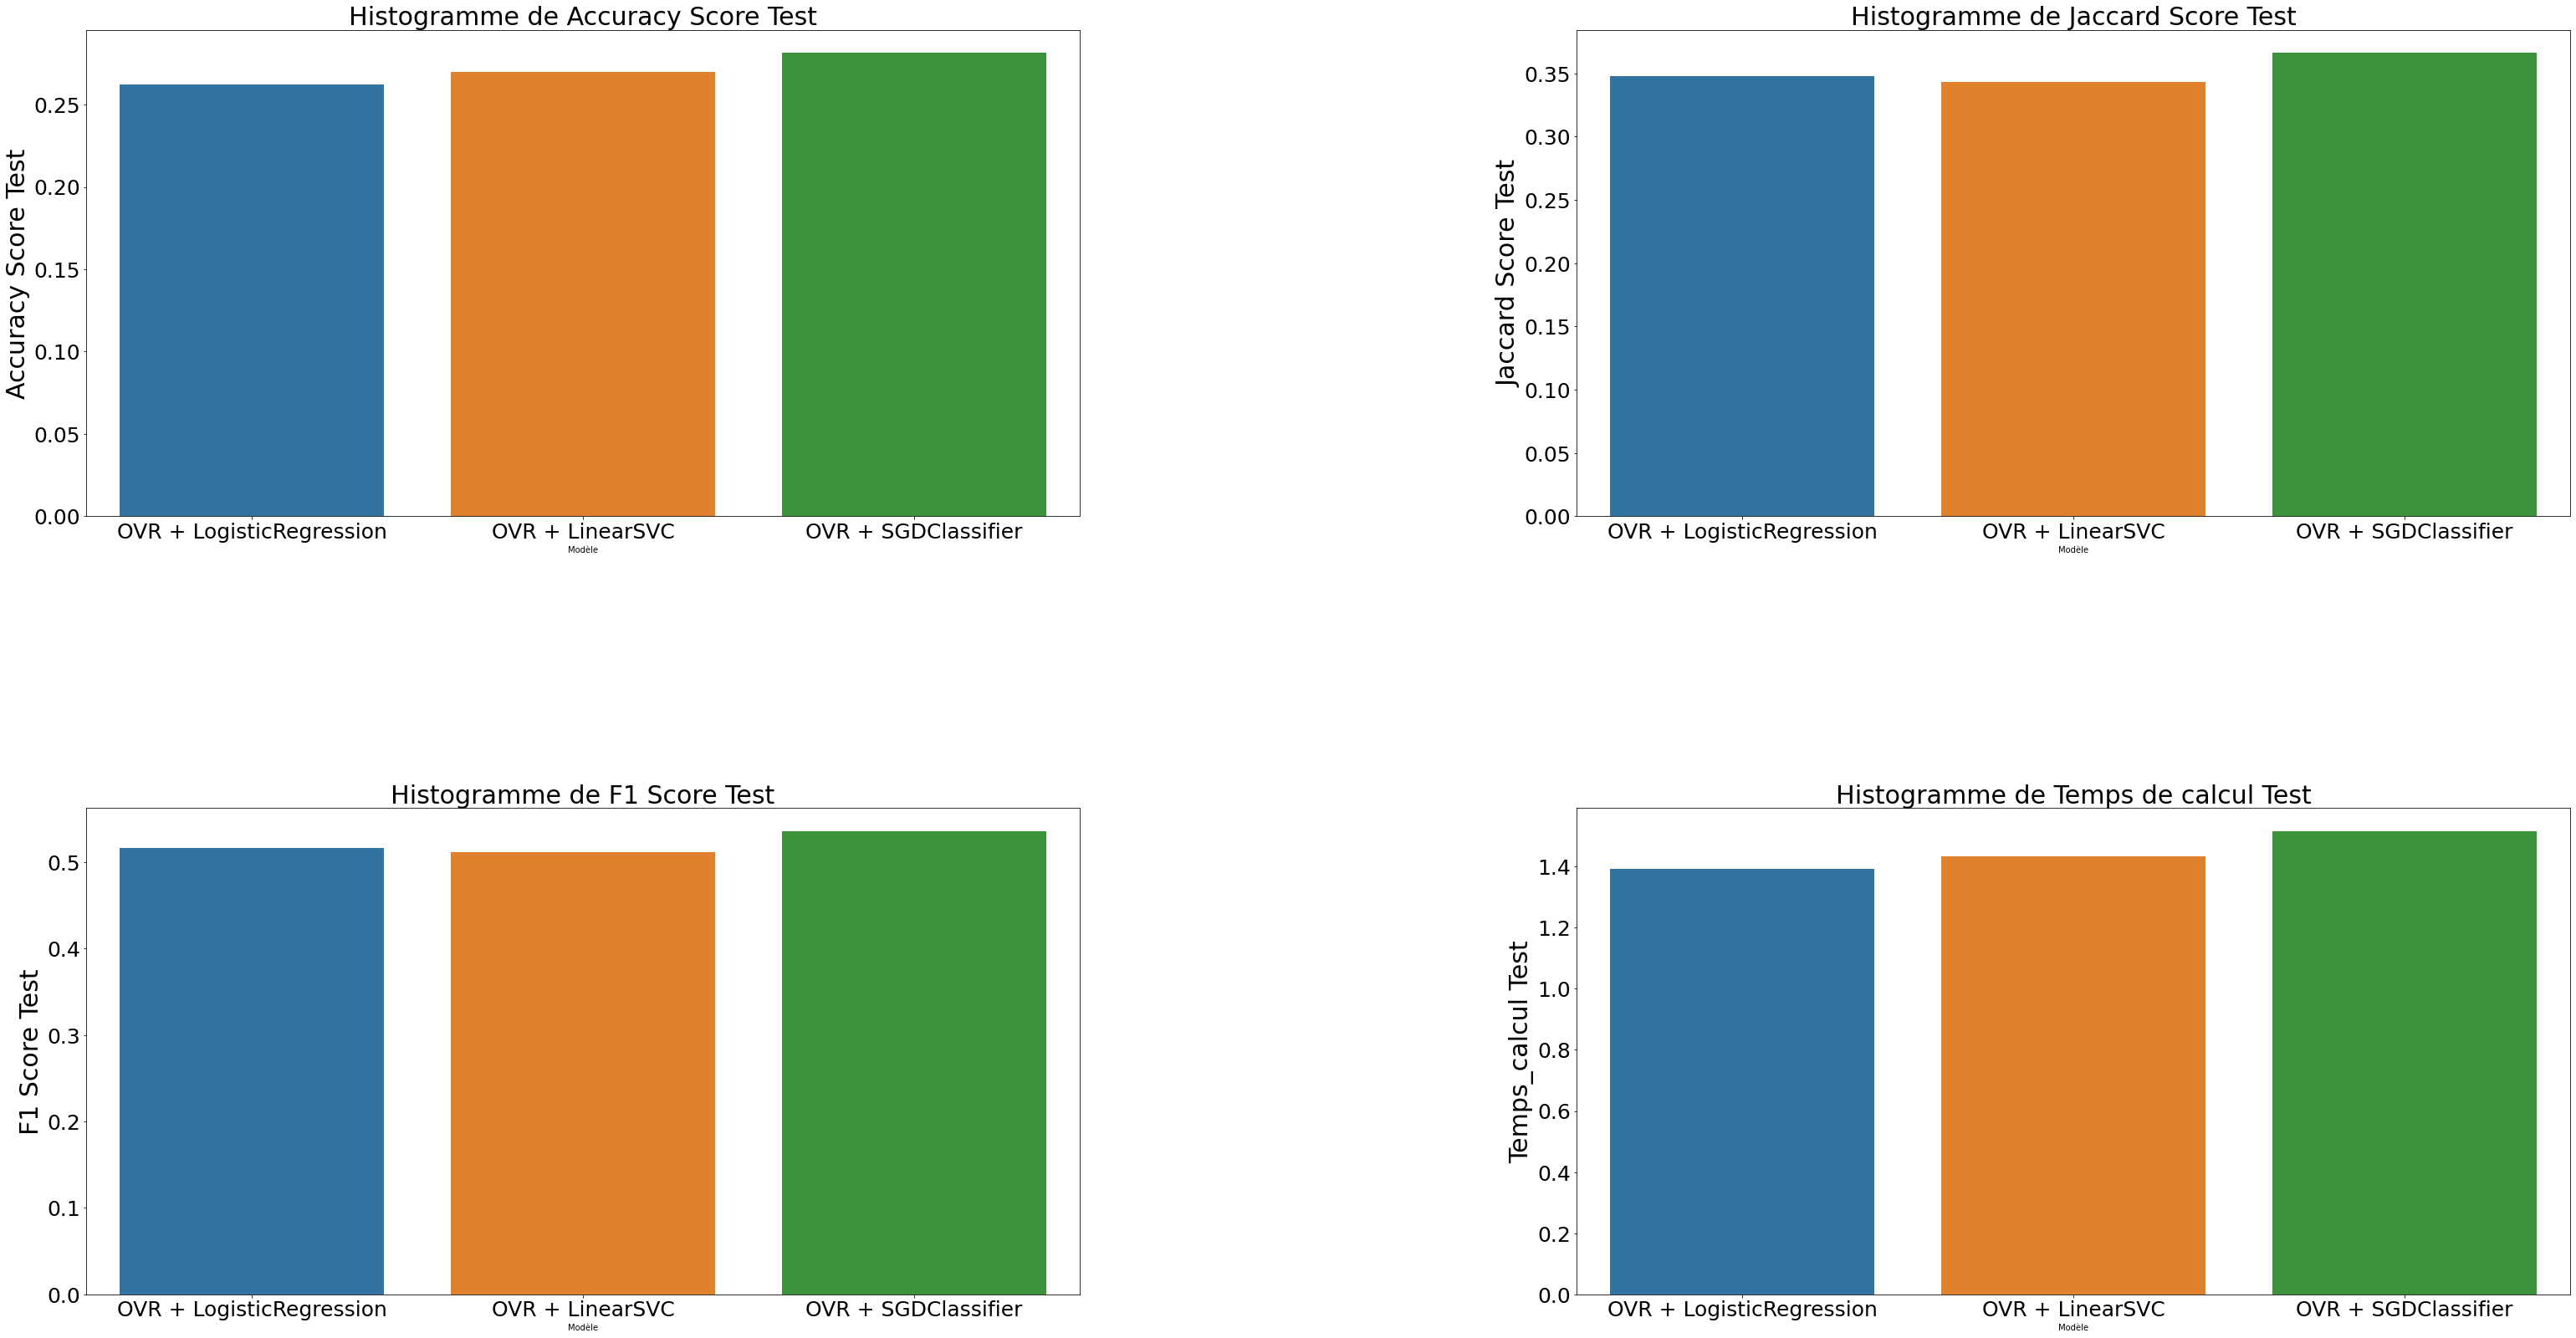

In [ ]:
plt.figure(1,figsize=(30,30))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1.5,
                          top = 0.9, wspace = 0.5, hspace = 0.6)

plt.subplot(2,2,1)
sns.barplot(x=tab_resultats['Modèle'],y=tab_resultats['accuracy_score_test'])
plt.tick_params(axis = 'both', labelsize = 25)
plt.ylabel("Accuracy Score Test", fontsize = 30)
plt.title('Histogramme de Accuracy Score Test', fontsize = 30)

plt.subplot(2,2,2)
sns.barplot(x=tab_resultats['Modèle'],y=tab_resultats['jaccard_score_test'])
plt.tick_params(axis = 'both', labelsize = 25)
plt.ylabel("Jaccard Score Test", fontsize = 30)
plt.title('Histogramme de Jaccard Score Test', fontsize = 30)

plt.subplot(2,2,3)
sns.barplot(x=tab_resultats['Modèle'],y=tab_resultats['F1_score_test'])
plt.tick_params(axis = 'both', labelsize = 25)
plt.ylabel("F1 Score Test", fontsize = 30)
plt.title('Histogramme de F1 Score Test', fontsize = 30)

plt.subplot(2,2,4)
sns.barplot(x=tab_resultats['Modèle'],y=tab_resultats['Temps_calcul_test'])
plt.tick_params(axis = 'both', labelsize = 25)
plt.ylabel("Temps_calcul Test", fontsize = 30)
plt.title('Histogramme de Temps de calcul Test', fontsize = 30)

plt.show()

# Approche supervisée : Classification des Tags à partir des messages normalisés sur Title

## Création des jeux de données

In [ ]:
## Vectorisation tf-idf des messages Title

tf_idf_vec = TfidfVectorizer()
tf_idf_data_title = tf_idf_vec.fit_transform(data['Title_nettoye_stopwords'])
tf_idf_data_title

<48447x19919 sparse matrix of type '<class 'numpy.float64'>'
	with 135077 stored elements in Compressed Sparse Row format>

In [ ]:
tf_idf_data_title.shape

(48447, 19919)

In [ ]:
data['Tags_nettoyes_liste'] = data.apply(lambda row : row['Tags_nettoyes'].split(', '), axis=1)
target = pd.get_dummies(data['Tags_nettoyes_liste'].apply(pd.Series).stack()).sum(level=0)
target = target.iloc[:, 1:]
target.shape

(48447, 100)

In [ ]:
## Séparation en jeu de données d'entrainement et de test

X_train, X_test, y_train, y_test = train_test_split(tf_idf_data_title, target, test_size=0.3) # 30% des données dans le jeu de test

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(33912, 19919)
(14535, 19919)
(33912, 100)
(14535, 100)


## Analyse sur le jeu d'entraînement et sélection des hyperparamètres par validation croisée

### One-versus-rest + LogisticRegression()

In [ ]:
param_grid = {'estimator__C' : [10, 1, 0.01, 0.001], 'estimator__penalty' : ['l1', 'l2']}

ovr_classifier = OneVsRestClassifier(LogisticRegression(n_jobs=-1, solver='saga'))

ovr_LogisticRegression = cross_validation(X_train,y_train, param_grid, ovr_classifier, 3)
resultats_cross_validation(ovr_LogisticRegression[0], ovr_LogisticRegression[1])

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'estimator__C': 10, 'estimator__penalty': 'l2'}
Résultats de la validation croisée :
accuracy = 0.205 (+/-0.006) for {'estimator__C': 10, 'estimator__penalty': 'l1'}
accuracy = 0.206 (+/-0.008) for {'estimator__C': 10, 'estimator__penalty': 'l2'}
accuracy = 0.201 (+/-0.005) for {'estimator__C': 1, 'estimator__penalty': 'l1'}
accuracy = 0.153 (+/-0.009) for {'estimator__C': 1, 'estimator__penalty': 'l2'}
accuracy = 0.081 (+/-0.005) for {'estimator__C': 0.01, 'estimator__penalty': 'l1'}
accuracy = 0.081 (+/-0.005) for {'estimator__C': 0.01, 'estimator__penalty': 'l2'}
accuracy = 0.081 (+/-0.005) for {'estimator__C': 0.001, 'estimator__penalty': 'l1'}
accuracy = 0.081 (+/-0.005) for {'estimator__C': 0.001, 'estimator__penalty': 'l2'}


In [ ]:
ovr_LogisticRegression_modele = modele_hyperparametre('OVR + LogisticRegression', X_train,y_train, X_test, y_test, ovr_LogisticRegression[0], ovr_LogisticRegression[1])

In [ ]:
print(ovr_LogisticRegression_modele[0])

['OVR + LogisticRegression', 0.41439608398207123, 0.4745518843393544, 0.643655729417712, 0.2212590299277606, 0.2582719876017048, 0.41051853676561156, 0.09774910699889006, 1.18448593499852, {'estimator__C': 10, 'estimator__penalty': 'l2'}]


### One-versus-rest + LinearSVC()

In [ ]:
param_grid = {'estimator__C' : [100, 10, 1, 0.01, 0.001], 'estimator__penalty': ['l1', 'l2']}

ovr_classifier = OneVsRestClassifier(LinearSVC(dual= False))

ovr_LinearSVC = cross_validation(X_train,y_train, param_grid, ovr_classifier, 3)
resultats_cross_validation(ovr_LinearSVC[0], ovr_LinearSVC[1])

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'estimator__C': 1, 'estimator__penalty': 'l2'}
Résultats de la validation croisée :
accuracy = 0.152 (+/-0.007) for {'estimator__C': 100, 'estimator__penalty': 'l1'}
accuracy = 0.154 (+/-0.005) for {'estimator__C': 100, 'estimator__penalty': 'l2'}
accuracy = 0.176 (+/-0.008) for {'estimator__C': 10, 'estimator__penalty': 'l1'}
accuracy = 0.187 (+/-0.005) for {'estimator__C': 10, 'estimator__penalty': 'l2'}
accuracy = 0.222 (+/-0.007) for {'estimator__C': 1, 'estimator__penalty': 'l1'}
accuracy = 0.223 (+/-0.008) for {'estimator__C': 1, 'estimator__penalty': 'l2'}
accuracy = 0.092 (+/-0.007) for {'estimator__C': 0.01, 'estimator__penalty': 'l1'}
accuracy = 0.086 (+/-0.007) for {'estimator__C': 0.01, 'estimator__penalty': 'l2'}
accuracy = 0.082 (+/-0.007) for {'estimator__C': 0.001, 'estimator__penalty': 'l1'}
accuracy = 0.082 (+/-0.007) for {'estimator__C': 0.001, 'estimator__penalty': 'l2'}


In [ ]:
ovr_LinearSVC_modele = modele_hyperparametre('OVR + LinearSVC', X_train,y_train, X_test, y_test, ovr_LinearSVC[0], ovr_LinearSVC[1])

In [ ]:
print(ovr_LinearSVC_modele[0])

['OVR + LinearSVC', 0.5162184477471101, 0.5512678968858981, 0.7107320379575238, 0.23109735122119024, 0.2778977404179841, 0.4349295434657976, 0.11886261399990872, 0.9922427779999907, {'estimator__C': 1, 'estimator__penalty': 'l2'}]


### One-versus-rest + SGDClassifier()

In [ ]:
param_grid = {'estimator__alpha' : [10, 1, 0.01, 0.001, 1e-04, 1e-05, 1e-06], 'estimator__penalty' : ['l1', 'l2']}

ovr_classifier = OneVsRestClassifier(SGDClassifier(n_jobs=-1))

ovr_SGDClassifier = cross_validation(X_train,y_train, param_grid, ovr_classifier, 3)
resultats_cross_validation(ovr_SGDClassifier[0], ovr_SGDClassifier[1])

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'estimator__alpha': 1e-05, 'estimator__penalty': 'l2'}
Résultats de la validation croisée :
accuracy = 0.082 (+/-0.007) for {'estimator__alpha': 10, 'estimator__penalty': 'l1'}
accuracy = 0.082 (+/-0.007) for {'estimator__alpha': 10, 'estimator__penalty': 'l2'}
accuracy = 0.082 (+/-0.007) for {'estimator__alpha': 1, 'estimator__penalty': 'l1'}
accuracy = 0.082 (+/-0.007) for {'estimator__alpha': 1, 'estimator__penalty': 'l2'}
accuracy = 0.082 (+/-0.007) for {'estimator__alpha': 0.01, 'estimator__penalty': 'l1'}
accuracy = 0.082 (+/-0.007) for {'estimator__alpha': 0.01, 'estimator__penalty': 'l2'}
accuracy = 0.119 (+/-0.002) for {'estimator__alpha': 0.001, 'estimator__penalty': 'l1'}
accuracy = 0.099 (+/-0.005) for {'estimator__alpha': 0.001, 'estimator__penalty': 'l2'}
accuracy = 0.200 (+/-0.009) for {'estimator__alpha': 0.0001, 'estimator__penalty': 'l1'}
accuracy = 0.197 (+/-0.008) for {'estimator__alpha': 0.0001, 'estimator__

In [ ]:
ovr_SGDClassifier_modele = modele_hyperparametre('OVR + SGDClassifier', X_train,y_train, X_test, y_test, ovr_SGDClassifier[0], ovr_SGDClassifier[1])

In [ ]:
print(ovr_SGDClassifier_modele[0])

['OVR + LogisticRegression', 0.5125029488086813, 0.5469029340624671, 0.7070940548625038, 0.23790849673202613, 0.2929674228983428, 0.4531706177741446, 0.10529163499995775, 0.9971837399999686, {'estimator__alpha': 1e-05, 'estimator__penalty': 'l2'}]


## Comparaison des modèles

In [ ]:
tab_resultats = pd.DataFrame(np.nan, index=np.arange(0), columns=['Modèle', 'accuracy_score_train', 'jaccard_score_train', 'F1_score_train', 'accuracy_score_test', 'jaccard_score_test', 'F1_score_test', 
                                                                  'Temps_calcul_train', 'Temps_calcul_test', 'Hyperparamètre']) 
tab_resultats

,Modèle,accuracy_score_train,jaccard_score_train,F1_score_train,accuracy_score_test,jaccard_score_test,F1_score_test,Temps_calcul_train,Temps_calcul_test,Hyperparamètre


In [ ]:
tab_resultats.loc[0] = ['OVR + LogisticRegression', 0.41439608398207123, 0.4745518843393544, 0.643655729417712, 0.2212590299277606, 0.2582719876017048, 0.41051853676561156, 0.09774910699889006, 1.18448593499852, {'estimator__C': 10, 'estimator__penalty': 'l2'}]
tab_resultats.loc[1] = ['OVR + LinearSVC', 0.5162184477471101, 0.5512678968858981, 0.7107320379575238, 0.23109735122119024, 0.2778977404179841, 0.4349295434657976, 0.11886261399990872, 0.9922427779999907, {'estimator__C': 1, 'estimator__penalty': 'l2'}]
tab_resultats.loc[2] = ['OVR + SGDClassifier', 0.5125029488086813, 0.5469029340624671, 0.7070940548625038, 0.23790849673202613, 0.2929674228983428, 0.4531706177741446, 0.10529163499995775, 0.9971837399999686, {'estimator__alpha': 1e-05, 'estimator__penalty': 'l2'}]

tab_resultats

,Modèle,accuracy_score_train,jaccard_score_train,F1_score_train,accuracy_score_test,jaccard_score_test,F1_score_test,Temps_calcul_train,Temps_calcul_test,Hyperparamètre
0,OVR + LogisticRegression,0.414396,0.474552,0.643656,0.221259,0.258272,0.410519,0.097749,1.184486,"{'estimator__C': 10, 'estimator__penalty': 'l2'}"
1,OVR + LinearSVC,0.516218,0.551268,0.710732,0.231097,0.277898,0.434930,0.118863,0.992243,"{'estimator__C': 1, 'estimator__penalty': 'l2'}"
2,OVR + SGDClassifier,0.512503,0.546903,0.707094,0.237908,0.292967,0.453171,0.105292,0.997184,"{'estimator__alpha': 1e-05, 'estimator__penalt..."


In [ ]:
tab_resultats.loc[0] = ovr_LogisticRegression_modele[0]
tab_resultats.loc[1] = ovr_LinearSVC_modele[0]
tab_resultats.loc[2] = ovr_SGDClassifier_modele[0]

tab_resultats

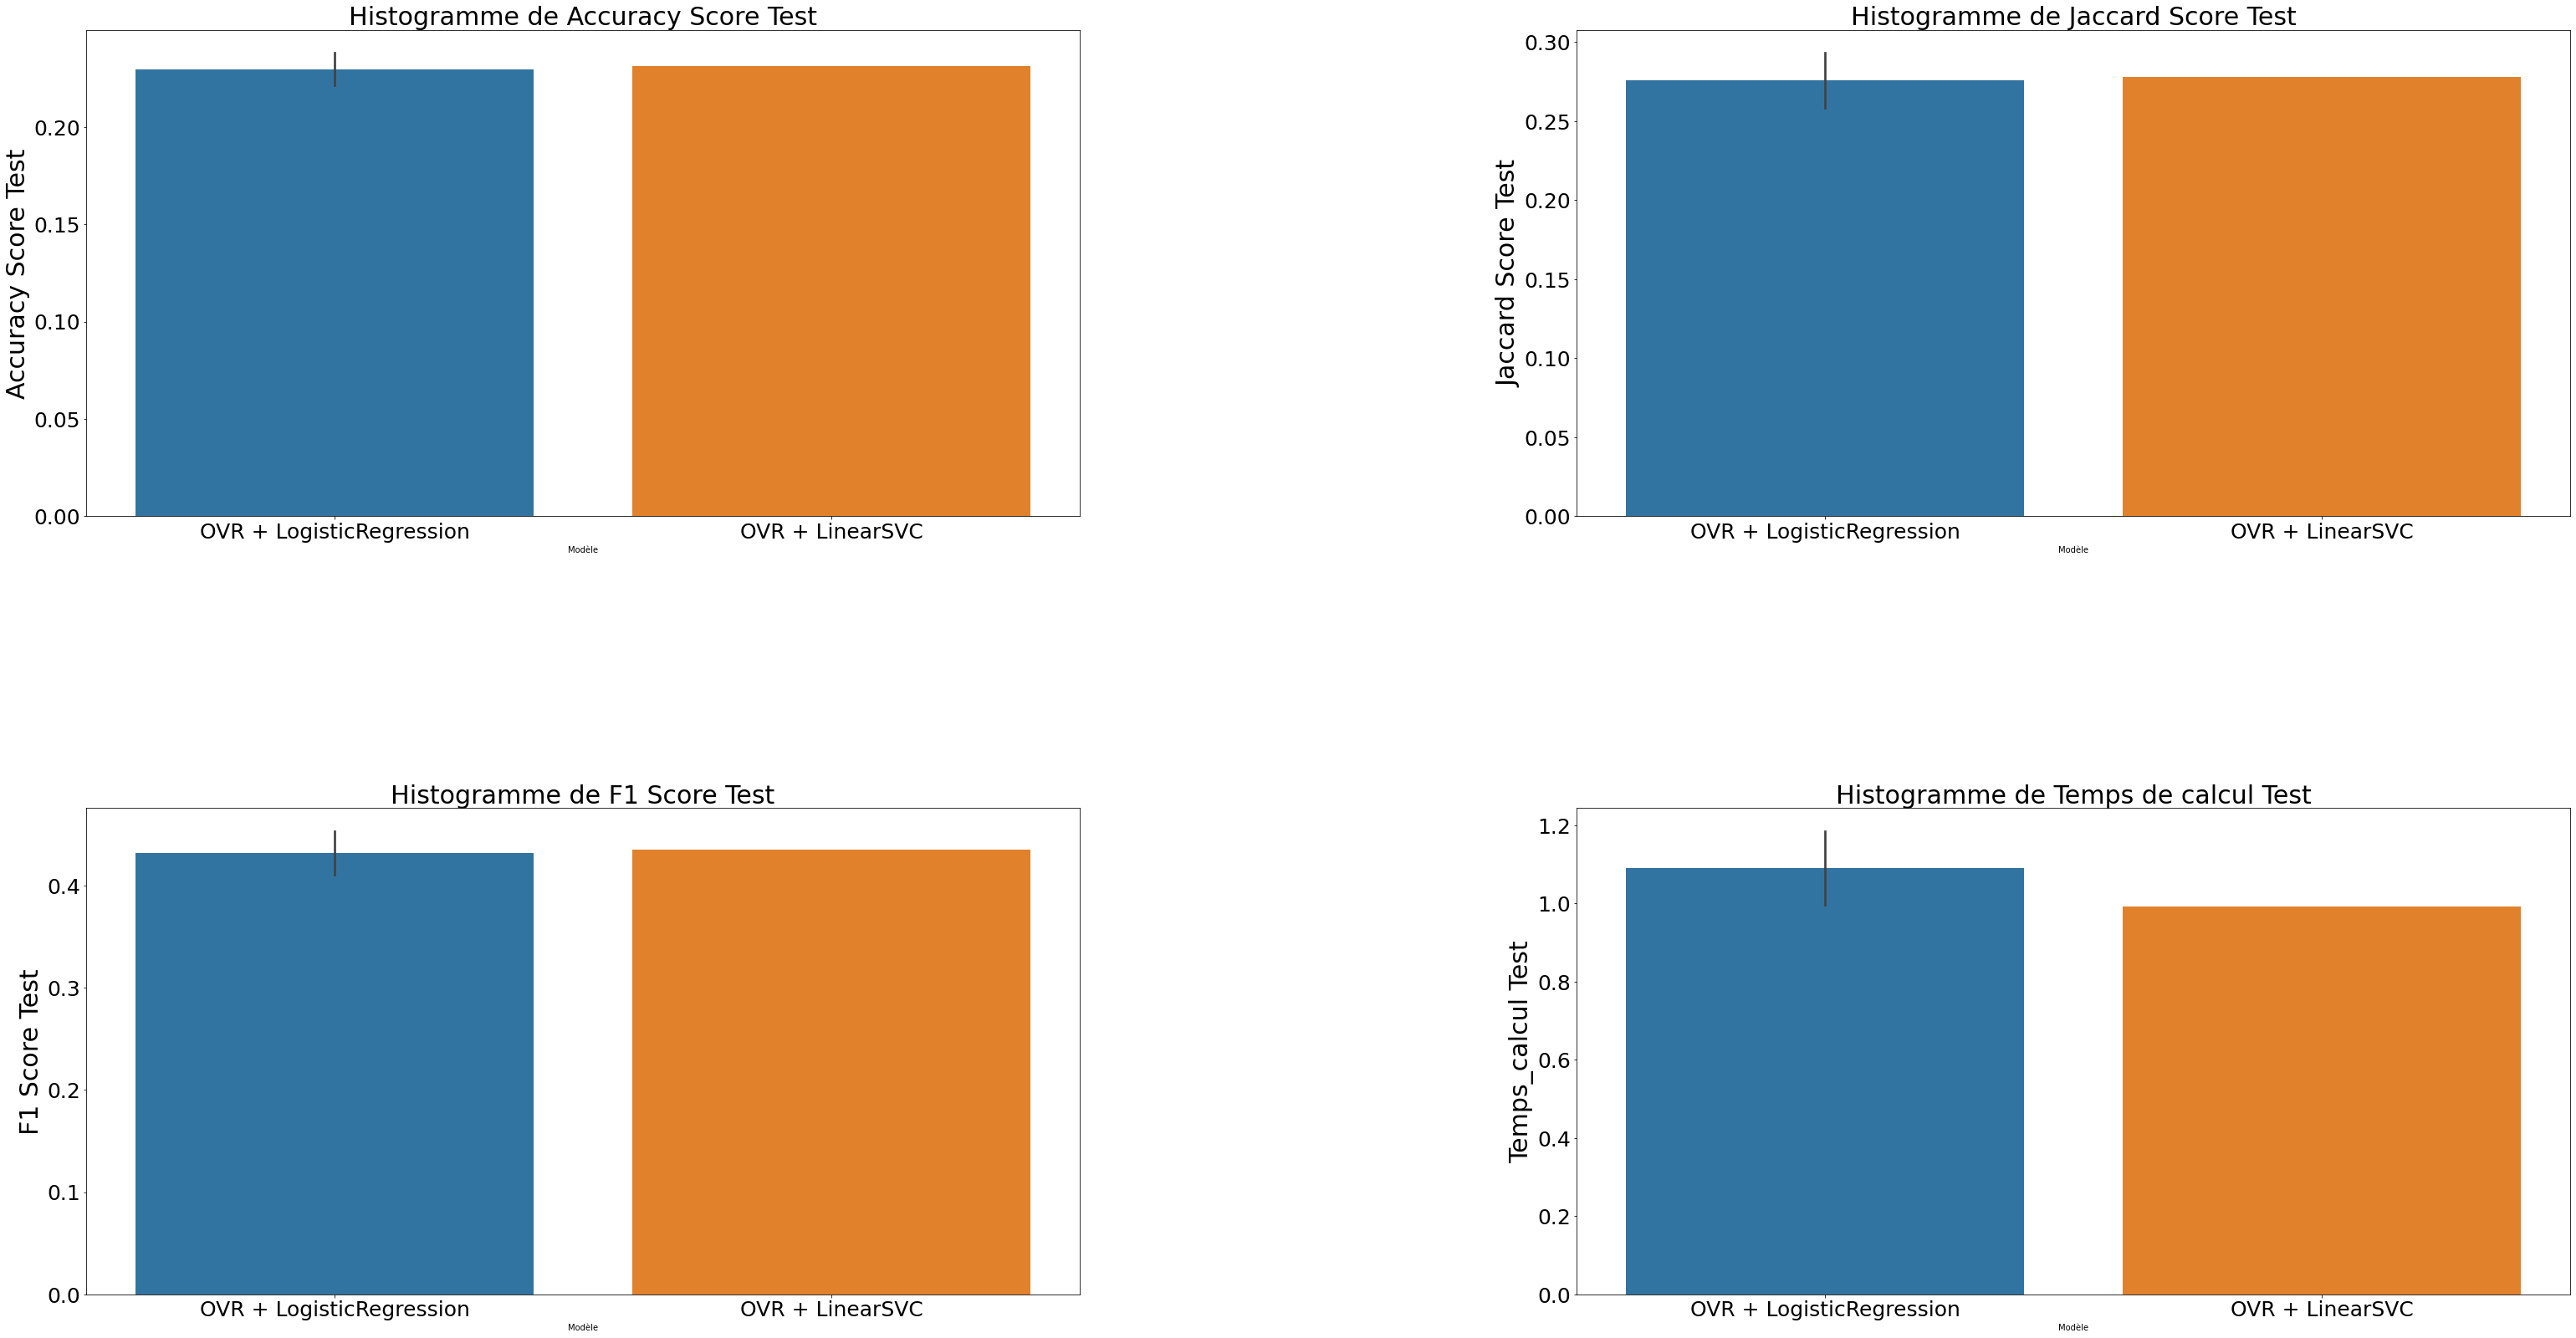

In [ ]:
plt.figure(1,figsize=(30,30))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1.5,
                          top = 0.9, wspace = 0.5, hspace = 0.6)

plt.subplot(2,2,1)
sns.barplot(x=tab_resultats['Modèle'],y=tab_resultats['accuracy_score_test'])
plt.tick_params(axis = 'both', labelsize = 25)
plt.ylabel("Accuracy Score Test", fontsize = 30)
plt.title('Histogramme de Accuracy Score Test', fontsize = 30)

plt.subplot(2,2,2)
sns.barplot(x=tab_resultats['Modèle'],y=tab_resultats['jaccard_score_test'])
plt.tick_params(axis = 'both', labelsize = 25)
plt.ylabel("Jaccard Score Test", fontsize = 30)
plt.title('Histogramme de Jaccard Score Test', fontsize = 30)

plt.subplot(2,2,3)
sns.barplot(x=tab_resultats['Modèle'],y=tab_resultats['F1_score_test'])
plt.tick_params(axis = 'both', labelsize = 25)
plt.ylabel("F1 Score Test", fontsize = 30)
plt.title('Histogramme de F1 Score Test', fontsize = 30)

plt.subplot(2,2,4)
sns.barplot(x=tab_resultats['Modèle'],y=tab_resultats['Temps_calcul_test'])
plt.tick_params(axis = 'both', labelsize = 25)
plt.ylabel("Temps_calcul Test", fontsize = 30)
plt.title('Histogramme de Temps de calcul Test', fontsize = 30)

plt.show()

# Comparaison des résultats des 2 approches

## Sélection des modèles pour l'Approche supervisée

In [ ]:
## Modèle OneVsRestClassifier(SGDClassifier()) pour Body

modele_final_sup_body = OneVsRestClassifier(SGDClassifier(penalty = 'l2', alpha = 1e-05))
modele_final_sup_body.fit(tf_idf_data_body, target)

OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05, average=False,
                                            class_weight=None,
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal',
                                            loss='hinge', max_iter=1000,
                                            n_iter_no_change=5, n_jobs=None,
                                            penalty='l2', power_t=0.5,
                                            random_state=None, shuffle=True,
                                            tol=0.001, validation_fraction=0.1,
                                            verbose=0, warm_start=False),
                    n_jobs=None)

In [ ]:
target_predict_body = pd.DataFrame(modele_final_sup_body.predict(tf_idf_data_body), columns=target.columns)

In [ ]:
## Exporation du modèle sélectionné pour Body

dump(modele_final_sup_body, 'modele_final_sup_body.joblib')
files.download('modele_final_sup_body.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
## Modèle OneVsRestClassifier(SGDClassifier()) pour Title

modele_final_sup_title = OneVsRestClassifier(SGDClassifier(penalty = 'l2', alpha = 1e-05))
modele_final_sup_title.fit(tf_idf_data_title, target)

OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05, average=False,
                                            class_weight=None,
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal',
                                            loss='hinge', max_iter=1000,
                                            n_iter_no_change=5, n_jobs=None,
                                            penalty='l2', power_t=0.5,
                                            random_state=None, shuffle=True,
                                            tol=0.001, validation_fraction=0.1,
                                            verbose=0, warm_start=False),
                    n_jobs=None)

In [ ]:
target_predict_title = pd.DataFrame(modele_final_sup_title.predict(tf_idf_data_title), columns=target.columns)

In [ ]:
## Exporation du modèle sélectionné pour Title

dump(modele_final_sup_title, 'modele_final_sup_title.joblib')
files.download('modele_final_sup_title.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Résultats de toutes les approches

In [ ]:
## Tansformation le DataFrame de dummies prédit en liste de Tags

def convert_dummie_columns(row):
  dummies = pd.DataFrame(row)
  dummies = dummies.rename_axis('index').reset_index()
  dummies.columns = ['Tags', 'Presence']
  Tags_predict = list(dummies[dummies['Presence'] == 1]['Tags'])
  return Tags_predict

In [ ]:
## Prédiction des Tags avec les 2 modèles de l'Approche supervisée

data['Tags_predict_Body'] = target_predict_body.apply(lambda row : convert_dummie_columns(row), axis=1)
data['Tags_predict_Title'] = target_predict_title.apply(lambda row : convert_dummie_columns(row), axis=1)

In [ ]:
data[['Tags_nettoyes', 'Tags_nettoyes_liste', 'match_Topic_dominant_Body', 'match_Topic_global_Body', 'match_Topic_dominant_Title', 'match_Topic_global_Title', 'Tags_predict_Body', 'Tags_predict_Title']]

,Tags_nettoyes,Tags_nettoyes_liste,match_Topic_dominant_Body,match_Topic_global_Body,match_Topic_dominant_Title,match_Topic_global_Title,Tags_predict_Body,Tags_predict_Title
0,python,[python],['text'],"['statement', 'text']",['auto'],['auto'],[python],[python]
1,python,[python],"['parameters', 'python', 'variables']","['dataset', 'array', 'questions', 'results', '...",[],[],[python],[python]
2,c++,[c++],[],"['program', 'check', 'number']",[],[],[],[]
3,r,[r],"['statements', 'section', 'statement', 'argume...","['part', 'columns', 'functions', 'section', 'v...",[],[],[],[]
4,"python, python-3.x","[python, python-3.x]","['modules', 'release']","['release', 'line', 'python', 'modules']",['attribute'],['attribute'],[python],"[python, python-3.x]"
...,...,...,...,...,...,...,...,...
48442,"ios, swift","[ios, swift]","['controller', 'mode']","['ios', 'mode', 'key', 'support', 'device', 'd...",['mode'],['mode'],"[ios, swift]",[]
48443,"android, reactjs, react-native","[android, reactjs, react-native]",['activity'],"['android', 'activity', 'react']",[],"['state', 'activity']","[android, reactjs]",[android]
48444,"javascript, jquery, html, css","[javascript, jquery, html, css]",['background'],"['part', 'background', 'page', 'site', 'picture']",[],[],"[css, html]",[]
48445,"c#, .net","[c#, .net]",['token'],"['key', 'documentation', 'libraries', 'notific...",['jwt'],['jwt'],[],[.net]


In [ ]:
## Pourcentage de présence des Tags Stack Overflow dans les prédictions

def pourcentage_ressemblance(row, variable):
  liste_tags_presents = [i for i in row['Tags_nettoyes_liste'] if i in row[variable]]
  pourcentage = len(liste_tags_presents)*100/len(row['Tags_nettoyes_liste'])
  return pourcentage

data['pourcentage_match_Topic_dominant_Body'] = data.apply(lambda row : pourcentage_ressemblance(row, 'match_Topic_dominant_Body'), axis=1)
data['pourcentage_match_Topic_global_Body'] = data.apply(lambda row : pourcentage_ressemblance(row, 'match_Topic_global_Body'), axis=1)
data['pourcentage_match_Topic_dominant_Title'] = data.apply(lambda row : pourcentage_ressemblance(row, 'match_Topic_dominant_Title'), axis=1)
data['pourcentage_match_Topic_global_Title'] = data.apply(lambda row : pourcentage_ressemblance(row, 'match_Topic_global_Title'), axis=1)
data['pourcentage_Tags_predict_Body'] = data.apply(lambda row : pourcentage_ressemblance(row, 'Tags_predict_Body'), axis=1)
data['pourcentage_Tags_predict_Title'] = data.apply(lambda row : pourcentage_ressemblance(row, 'Tags_predict_Title'), axis=1)

In [ ]:
data[['Tags_nettoyes', 'Tags_nettoyes_liste', 'pourcentage_match_Topic_dominant_Body', 'pourcentage_match_Topic_global_Body', 'pourcentage_match_Topic_dominant_Title', 'pourcentage_match_Topic_global_Title', 'pourcentage_Tags_predict_Body', 'pourcentage_Tags_predict_Title']]

,Tags_nettoyes,Tags_nettoyes_liste,pourcentage_match_Topic_dominant_Body,pourcentage_match_Topic_global_Body,pourcentage_match_Topic_dominant_Title,pourcentage_match_Topic_global_Title,pourcentage_Tags_predict_Body,pourcentage_Tags_predict_Title
0,python,[python],0.0,0.000000,0.0,0.0,100.000000,100.000000
1,python,[python],100.0,100.000000,0.0,0.0,100.000000,100.000000
2,c++,[c++],0.0,0.000000,0.0,0.0,0.000000,0.000000
3,r,[r],100.0,100.000000,0.0,0.0,0.000000,0.000000
4,"python, python-3.x","[python, python-3.x]",0.0,50.000000,0.0,0.0,50.000000,100.000000
...,...,...,...,...,...,...,...,...
48442,"ios, swift","[ios, swift]",0.0,50.000000,0.0,0.0,100.000000,0.000000
48443,"android, reactjs, react-native","[android, reactjs, react-native]",0.0,33.333333,0.0,0.0,66.666667,33.333333
48444,"javascript, jquery, html, css","[javascript, jquery, html, css]",0.0,0.000000,0.0,0.0,50.000000,0.000000
48445,"c#, .net","[c#, .net]",0.0,0.000000,0.0,0.0,0.000000,50.000000


In [ ]:
data[['pourcentage_match_Topic_dominant_Body', 'pourcentage_match_Topic_global_Body', 'pourcentage_match_Topic_dominant_Title', 'pourcentage_match_Topic_global_Title', 'pourcentage_Tags_predict_Body', 'pourcentage_Tags_predict_Title']].describe(include='all')

,pourcentage_match_Topic_dominant_Body,pourcentage_match_Topic_global_Body,pourcentage_match_Topic_dominant_Title,pourcentage_match_Topic_global_Title,pourcentage_Tags_predict_Body,pourcentage_Tags_predict_Title
count,48447.000000,48447.000000,48447.000000,48447.000000,48447.000000,48447.000000
mean,17.397603,31.693328,13.965983,17.863714,62.293847,47.724730
std,35.092636,41.438861,32.597717,35.247951,42.604553,44.797931
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,100.000000,50.000000
75%,0.000000,50.000000,0.000000,0.000000,100.000000,100.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


Text(0.5, 1.0, 'Boxplot des pourcentages de prédiction de chaque approche')

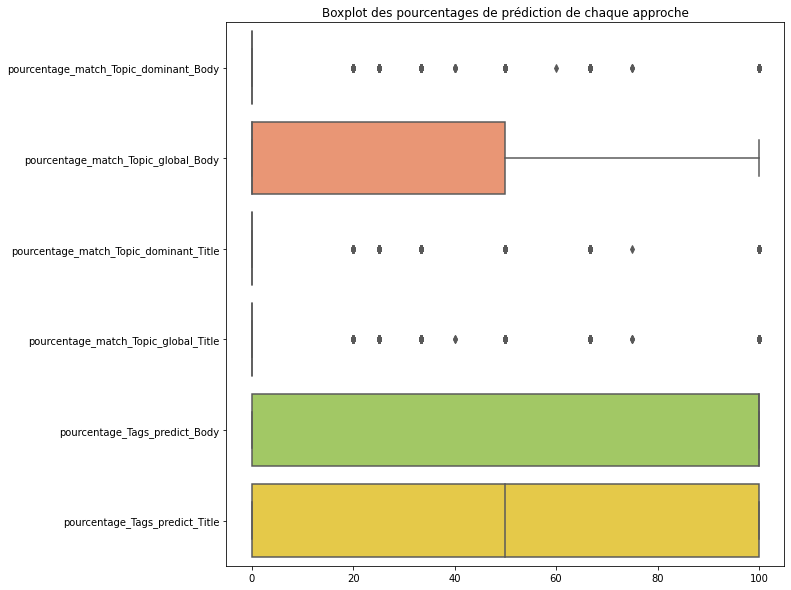

In [ ]:
## Boxplot des pourcentages de prédiction de toutes les approches

plt.rcParams["figure.figsize"] = (10, 10)
sns.boxplot(data = data[['pourcentage_match_Topic_dominant_Body', 'pourcentage_match_Topic_global_Body', 'pourcentage_match_Topic_dominant_Title', 'pourcentage_match_Topic_global_Title', 'pourcentage_Tags_predict_Body', 'pourcentage_Tags_predict_Title']], 
            orient="h", palette="Set2").set_title('Boxplot des pourcentages de prédiction de chaque approche')